In [3]:
import pandas
import numpy
import datetime
import matplotlib
import os
%matplotlib inline

os.chdir('/Users/cds/Desktop/Hobbies/groupme/groupme-tools-master')
os.system('python groupme-fetch.py 8322711 ec997910f1430132b91122335db17b7f newest $(python newest-id.py transcript-8322711.json)')
data = pandas.read_json('/Users/cds/Desktop/Hobbies/groupme/groupme-tools-master/transcript-8322711.json')

In [9]:
## adding fields, indicators, etc
data = data.replace([None], [""])
from datetime import timedelta
data['nfavs'] = data.favorited_by.map(len)
data['created_at'] = pandas.to_datetime(data['created_at'])
data['timestamp'] = data.created_at - timedelta(hours=4)
data['weekday'] = data['timestamp'].dt.dayofweek
data['date'] = data['timestamp'].dt.date.astype(str)
data['hour'] = data['timestamp'].dt.hour
data['minute'] = data['timestamp'].dt.minute
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['week'] = data.timestamp.dt.week
data['weekend'] = data['weekday'] > 4
data['picture_url'] = data.picture_url.astype(str)
data['gif'] = map(lambda x: 'gif' in x, data.picture_url)
data['yearmonth'] = data['timestamp'].map(lambda x: int('{year}{month}'.format(year=x.year,month=x.month)))
data['nchar'] = data.text.str.len()
data['one'] = 1
print data.dtypes

avatar_url              object
created_at      datetime64[ns]
favorited_by            object
group_id                 int64
id                       int64
location                object
name                    object
picture_url             object
source_guid             object
system                    bool
text                    object
user_id                 object
nfavs                    int64
timestamp       datetime64[ns]
weekday                  int64
date                    object
hour                     int64
minute                   int64
year                     int64
month                    int64
day                      int64
week                     int64
weekend                   bool
gif                       bool
yearmonth                int64
nchar                    int64
one                      int64
dtype: object


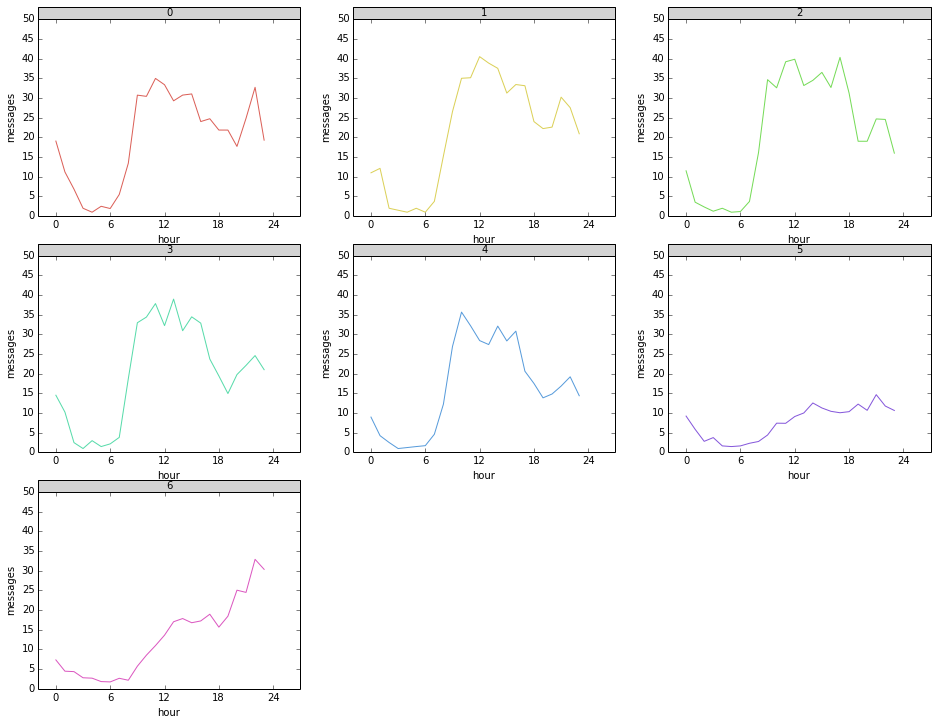

<ggplot: (288348925)>


In [6]:
# average messages/hour for each day of week

from ggplot import *

dta = data.groupby(['year', 'month', 'day', 'weekday', 'hour'], as_index = False)['timestamp'].count()
dta = dta.groupby(['weekday', 'hour'], as_index = False)['timestamp'].mean()
dta.columns = ['weekday', 'hour', 'messages']

gsize = theme_matplotlib(rc={"figure.figsize": "16, 12"}, matplotlib_defaults=False)
p = ggplot(aes(x='hour', y='messages', color = 'weekday'), data = dta) + geom_line() \
+ facet_wrap('weekday') + gsize + ylim(0, 50)
print p

In [7]:
## userid, name lookup
names = data[data['user_id'] != 'system'].groupby('user_id', as_index = False)
names = names.agg({'timestamp': [numpy.min, numpy.max], \
                   'nfavs': [numpy.sum], \
                   'one': [numpy.sum]})
names.columns = ['user_id', 'first_day', 'timestamp', 'favs_in', 'cnt']
names = pandas.merge(names, data, 'inner')
names = names[['user_id', 'name', 'first_day', 'timestamp', 'favs_in', 'cnt']]
names = names[names['name'] != 'Tim Steinmetz']
names['user_id'] = names.user_id.astype(int)
names['total_days'] = names.timestamp - names.first_day
names['total_days'] = names.total_days.astype(int)/60/60/24/1000000000
names['weekdays'] = names.total_days*5/7
names['weekends'] = names.total_days*2/7
print names

ValueError: invalid literal for long() with base 10: 'calendar'

In [8]:
from ggplot import *

dta = data[data['user_id'] != 'system']
dta = dta.groupby(['weekend', 'user_id', 'hour'], as_index = False)['timestamp'].count()
dta.columns = ['weekend', 'user_id', 'hour', 'messages']
dta = pandas.merge(dta, names, 'inner')
dta['messages_per_day'] = dta.messages/(dta.weekend.astype(int)*dta.weekends + abs(dta.weekend.astype(int) - 1)*dta.weekdays)
gsize = theme_matplotlib(rc={"figure.figsize": "15, 10"}, matplotlib_defaults=False)
p = ggplot(aes(x='hour', y='messages_per_day', color = 'weekend'), data = dta) + geom_line() \
+ facet_wrap('name') + gsize + ylim(0, dta.messages_per_day.max())
#print p
#print dta

ValueError: invalid literal for long() with base 10: 'calendar'

In [17]:
## average gif size by user

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        s = s[start:end]
        return s
    except ValueError:
        return 0

size_x = map(lambda x: find_between(x, 'com/', 'x'), data.picture_url)
size_y = map(lambda x: find_between(x, 'x', '.'), data.picture_url)
size_x = map(int, size_x)
size_y = map(int, size_y)
data['image_size'] = map(lambda x,y: x*y, size_x, size_y)

us = data[data['image_size']>0 & data['gif']].groupby('user_id', as_index = False)['image_size']
us = us.agg({'image_size': [numpy.mean]})
us.columns = ['user_id', 'avg_size']
us['user_id'] = us.user_id.astype(int)
us = pandas.merge(us, names, 'inner')
us = us.sort('avg_size', ascending = 0)
us = us[['user_id', 'avg_size', 'name']]
#print us

In [109]:
## the 12+ like comments
temp = data[(data['nfavs'] > 11)][['name', 'text']]
#temp.to_csv

In [15]:
# average message size
avgchars = data[data['user_id'] != 'system'].groupby('user_id', as_index = False)
avgchars = avgchars.agg({'nchar': [numpy.min, numpy.max, numpy.mean, numpy.sum]})
avgchars.columns = ['user_id', 'min', 'max', 'mean', 'sum']
avgchars['user_id'] = avgchars.user_id.astype(int)
avgchars = pandas.merge(names, avgchars, 'inner')
avgchars = avgchars[['name', 'mean', 'max']]
#avgchars.sort('mean', ascending = 0)

In [23]:
def count_likes( user, col ):
    liked = data.favorited_by.astype(str).str.contains(user)
    cnts = len(liked[liked])
    return cnts

names['favs_out'] = [0] * len(names.index)
x = 1
for i in names.user_id.astype(str):
    likes = count_likes( i, data.favorited_by )
    names.favs_out[x] = likes
    x = x+1

names['favs_in_pm'] = names.favs_in/names.cnt
names['favs_out_pm'] = names.favs_out/names.cnt
names['favs_in_favs_out'] = names.favs_in/names.favs_out

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
